# Image Caption Generation

## Text preparation 

Building a vocabulary.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Mounted Drive when using Google Colab; otherwise, local path to be specified
root = "drive/My Drive/Colab Notebooks/data/Flickr8k/"
caption_dir = root + "captions/"
image_dir = root + "images/"


token_file = "Flickr8k.token.txt"

A helper function to read in ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r') # opens file in read mode
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip()) # strip() removes spaces at the beginning and end of a string
    file.close()
    return lines

Reading all the ground truth captions (5 per image), into memory

In [0]:
lines = read_lines(caption_dir + token_file)

In [5]:
lines[:5] # Return first 5 ground truth captions (from beginning (index 0) to index 4)

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intialize, both ID and word dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word): # __call__ implements function call operator on object of class
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

- Extracting all the words from ```lines```, and creating a list of them in a variable ```words```. 
- Extracting the image ids from ```lines```, and creating a list of them in a variable ```image_ids```. 
- Extracting and cleaning (removing punctuations) each caption in ```lines```, and creating a list of the ```cleanded_captions```.

In [0]:
import string

punctuations = string.punctuation
words = []
cleaned_captions = [] #List of cleaned captions
image_ids = [] #List of image ids

for line in lines:
  sentence = line.split('\t')[-1]
  image_id = line.split('\t')[0].split('.')[0]
  image_ids.append(image_id)
  strings = sentence.split(' ')
  cleaned_caption = ""
  
  for word in strings:
    if word not in punctuations and word[0] is not "'":
      words.append(word.lower())
      cleaned_caption += word.lower() + ' '

  cleaned_captions.append(cleaned_caption.strip())

Building the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Adding the rest of the words from the parsed captions that appear more than three times:

In [0]:
from collections import Counter
d = dict(Counter(words))

In [0]:
for key, value in d.items():
  if value > 3:
    vocab.add_word(key)

In [11]:
len(vocab)

3433

## Dataset and loaders for training

In [12]:
len(cleaned_captions)

40455

In [13]:
len(image_ids)

40455

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [15]:
data_df.head(n=5)

,image_id,path,caption
0,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flickr8k/i...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flickr8k/i...,a girl going into a wooden building
2,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flickr8k/i...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flickr8k/i...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flickr8k/i...,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

More info here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Ratio of train/test data.

# Calculating train size to help group captions in such a way that each dataset contains all 5 captions of an image
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Writing the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

In [0]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    collate_fn=caption_collate_fn )

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=5,
    collate_fn=caption_collate_fn )

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keeping all layers except the last one
        # Unpacking the layers and creating a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # ResNet layer put in a with torch.no_grad() block to prevent updating of the weights during training
        with torch.no_grad():
          features = self.resnet(images)

        features = torch.flatten(features, 1)
        features = self.linear(features)
        features = self.bn(features)

        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # Embedding layer to compress the input feature space from Encoder network into a smaller space (embed_size).
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Defining the RNN and LSTM layers (ran one at a time)
        # self.lstm / self.rnn
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # "Packing" the padded sequence of captions to reduce compute time
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.rnn(packed) 
        #hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)
            #hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [42]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

Initializing the models and setting the learning parameters.

In [0]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

iterator = iter(test_loader)

In [0]:
#Get two image and caption tensors from test loader

images1, captions1, _ = iterator.next()
images2, captions2, _ = iterator.next()

In [0]:
#Function to display image and generate and compare captions with reference captions
def generate_and_compare_captions(image_tensor, caption_tensors):
  image = np.transpose(image_tensor.squeeze(0).numpy(), (1,2,0)) #convert image_tensor to numpy array for display
  image = (image - np.min(image))/(np.max(image) - np.min(image))
  captions_array = caption_tensors.numpy()


  reference_caption = []

  token_words = ['<start>', '<end>', '<pad>']

  #Convert caption indexes to words
  for caption_array in captions_array:
    caption_list = []
    for c in caption_array:
      caption_list.append(vocab.idx2word.get(c))
    
    #Remove token words in list from captions
    for token in token_words:
      for word in caption_list:
        if token == word:
          while word in caption_list:
            caption_list.remove(token)

    reference_caption.append(caption_list)

  fig = plt.figure()
  plt.imshow(image)
  plt.axis('off')
  fig.show()

  for caption in reference_caption:
    print(caption)

  #Generate caption
  image_tensor = image_tensor.unsqueeze(0).to(device)

  features = encoder(image_tensor)
  output = decoder.sample(features).squeeze(0).cpu().numpy()

  #Convert caption indexes to words
  generated_caption_list = []
  for c in output:
    generated_caption_list.append(vocab.idx2word.get(c))

    #Remove token words in list from captions
    for token in token_words:
      for word in generated_caption_list:
        if token == word:
          while word in generated_caption_list:
            generated_caption_list.remove(token)

  generated_caption = ' '.join(generated_caption_list)
  print('Generated caption: ', generated_caption)

  #Calculate BLEU score
  bleu_score = sentence_bleu(reference_caption, generated_caption_list)
  print('BLEU score: ', bleu_score)

Generates sample caption from two test set images before training

['a', 'child', 'playing', 'on', 'the', 'monkey', 'bars', 'at', 'a', 'playground', 'with', 'an', 'adult', '<unk>']
['a', 'kid', 'hangs', 'upside', 'down', 'on', 'the', 'monkey', 'bars', 'at', 'a', 'playground']
['a', 'young', 'children', 'hanging', 'upside', 'at', 'the', 'playground']
['girl', 'hanging', 'upside', 'down', 'on', 'blue', 'monkey', 'bars']
['a', 'girl', 'hangs', 'on', 'the', 'bars']
Generated caption:  gray big case whilst log motion things wild says van hoodie feathers series pit seems sofa squeezing fish rifles wave
BLEU score:  0
['collie', 'jumping', 'over', 'a', 'training', 'hurdle', 'that', 'is', 'on', 'the', 'grass']
['a', 'brown', 'and', 'white', 'sheltie', 'leaping', 'over', 'a', 'rail']
['a', 'collie', 'is', 'running', 'through', 'an', 'obstacle', 'course']
['collie', 'making', 'a', 'jump', 'over', 'a', 'yellow', 'hurdle']
['the', 'dog', 'is', 'leaping', 'over', 'a', 'hurdle']
Generated caption:  punches amongst genocide ollies follow coffee surf colorfully lion 

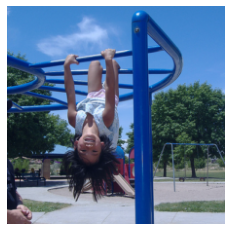

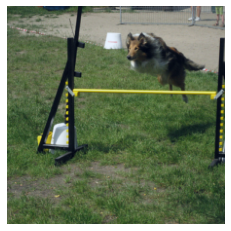

In [47]:
encoder.eval()

generate_and_compare_captions(images1[0], captions1)
generate_and_compare_captions(images2[0], captions2)

## Training the model

The loop to train the model.

Epoch [0/5], Step [0/301], Loss: 8.1604
Epoch [0/5], Step [10/301], Loss: 5.3213
Epoch [0/5], Step [20/301], Loss: 5.1069
Epoch [0/5], Step [30/301], Loss: 4.6832
Epoch [0/5], Step [40/301], Loss: 4.4072
Epoch [0/5], Step [50/301], Loss: 4.1532
Epoch [0/5], Step [60/301], Loss: 3.9709
Epoch [0/5], Step [70/301], Loss: 3.8925
Epoch [0/5], Step [80/301], Loss: 3.7023
Epoch [0/5], Step [90/301], Loss: 3.7239
Epoch [0/5], Step [100/301], Loss: 3.5293
Epoch [0/5], Step [110/301], Loss: 3.4794
Epoch [0/5], Step [120/301], Loss: 3.6432
Epoch [0/5], Step [130/301], Loss: 3.4946
Epoch [0/5], Step [140/301], Loss: 3.4560
Epoch [0/5], Step [150/301], Loss: 3.1969
Epoch [0/5], Step [160/301], Loss: 3.3948
Epoch [0/5], Step [170/301], Loss: 3.3338
Epoch [0/5], Step [180/301], Loss: 3.3444
Epoch [0/5], Step [190/301], Loss: 3.1421
Epoch [0/5], Step [200/301], Loss: 3.3330
Epoch [0/5], Step [210/301], Loss: 3.1597
Epoch [0/5], Step [220/301], Loss: 3.2580
Epoch [0/5], Step [230/301], Loss: 3.2614
Epo

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch [1/5], Step [0/301], Loss: 2.8932
Epoch [1/5], Step [10/301], Loss: 3.0520
Epoch [1/5], Step [20/301], Loss: 3.0133
Epoch [1/5], Step [30/301], Loss: 3.0276
Epoch [1/5], Step [40/301], Loss: 3.0394
Epoch [1/5], Step [50/301], Loss: 2.9234
Epoch [1/5], Step [60/301], Loss: 2.9356
Epoch [1/5], Step [70/301], Loss: 2.8891
Epoch [1/5], Step [80/301], Loss: 2.8070
Epoch [1/5], Step [90/301], Loss: 3.0085
Epoch [1/5], Step [100/301], Loss: 2.8232
Epoch [1/5], Step [110/301], Loss: 2.9380
Epoch [1/5], Step [120/301], Loss: 2.9158
Epoch [1/5], Step [130/301], Loss: 2.7890
Epoch [1/5], Step [140/301], Loss: 2.7315
Epoch [1/5], Step [150/301], Loss: 2.9865
Epoch [1/5], Step [160/301], Loss: 2.9448
Epoch [1/5], Step [170/301], Loss: 2.9048
Epoch [1/5], Step [180/301], Loss: 2.8301
Epoch [1/5], Step [190/301], Loss: 2.9046
Epoch [1/5], Step [200/301], Loss: 2.9512
Epoch [1/5], Step [210/301], Loss: 2.7741
Epoch [1/5], Step [220/301], Loss: 2.8528
Epoch [1/5], Step [230/301], Loss: 2.8133
Epo

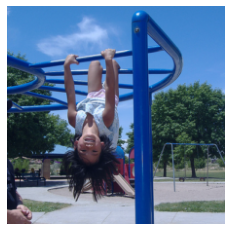

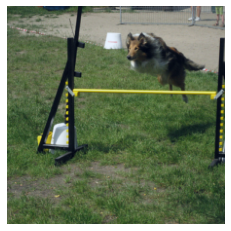

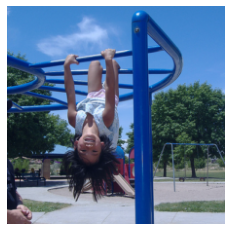

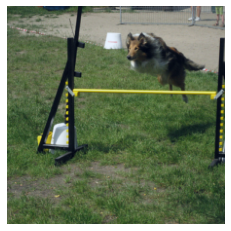

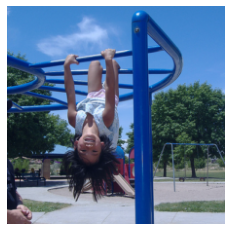

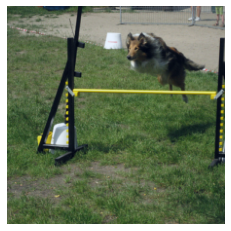

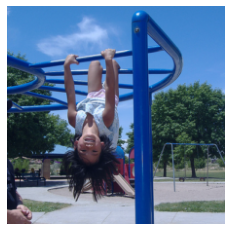

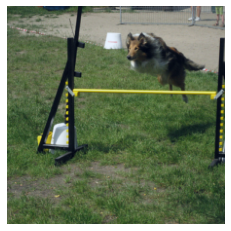

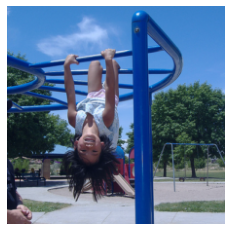

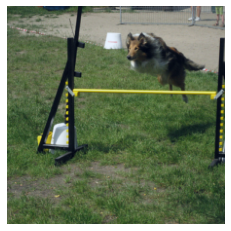

In [48]:
training_losses = []
bleu_scores_1 = []
bleu_scores_2 = []
# Train the models
total_step = len(train_loader)
for epoch in range(num_epochs):

    encoder.train()
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 
            training_losses.append(loss.item())

        # Uncomment to save the model checkpoints
        # Save RNN and LSTM versions separately
        # if (i+1) % save_step == 0:
        #   torch.save(decoder.state_dict(), model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        #   torch.save(encoder.state_dict(), model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

    encoder.eval()
    generate_and_compare_captions(images1[0], captions1)
    generate_and_compare_captions(images2[0], captions2)

In [0]:
#Save fully trained decoder and encoder networks
torch.save(decoder.state_dict(), 'decoder-rnn.ckpt')
torch.save(encoder.state_dict(), 'encoder-rnn.ckpt')

In [0]:
#Load encoder and decoder networks and use it to run the 5 images

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

encoder.load_state_dict(torch.load('encoder-rnn.ckpt', map_location=device))
decoder.load_state_dict(torch.load('decoder-rnn.ckpt', map_location=device))

Generating captions for five additional test images and displaying along with BLEU scores and reference captions.

['a', 'man', 'is', 'playing', 'with', 'a', 'fire', 'baton', 'in', 'the', 'day', 'light']
['the', 'guy', 'is', 'holding', 'a', 'black', 'stick', 'in', 'front', 'of', 'a', 'playground']
['a', 'man', 'stands', 'near', 'a', 'playground']
['a', 'man', 'juggling', 'fire']
['man', 'throws', 'flames', 'outside']
Generated caption:  a man in a black shirt is jumping off a ramp
BLEU score:  0.5247661627436951
['a', 'girl', 'is', 'doing', 'the', 'splits', 'in', 'the', 'air', 'in', 'front', 'of', 'some', 'trees']
['a', 'young', 'girl', 'doing', 'a', 'trick', 'in', 'midair', 'in', 'front', 'of', 'a', 'tree']
['a', 'woman', 'grabbing', 'her', 'feet', 'while', 'jumping', 'in', 'front', 'of', 'trees']
['jumping', 'girl', 'grabs', 'her', 'feet', 'plants', 'in', 'background']
['a', 'girl', 'doing', 'the', 'splits', 'in', 'midair']
Generated caption:  a girl in a yellow shirt and blue jeans is jumping on a trampoline
BLEU score:  0.4428500142691474
['a', 'man', 'wearing', 'a', 'white', 'helmet', 'is', 'i

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


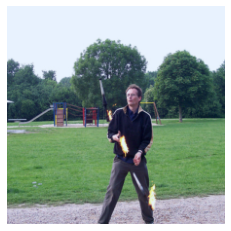

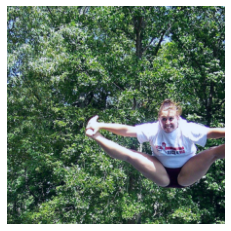

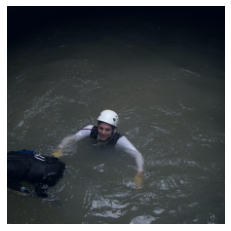

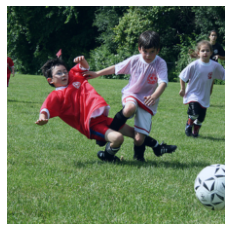

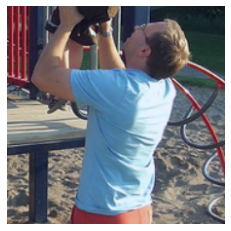

In [50]:
image_tensor3, caption_tensor3, _ = iterator.next()
image_tensor4, caption_tensor4, _ = iterator.next()
image_tensor5, caption_tensor5, _ = iterator.next()
image_tensor6, caption_tensor6, _ = iterator.next()
image_tensor7, caption_tensor7, _ = iterator.next()

encoder.eval()

generate_and_compare_captions(image_tensor3[0], caption_tensor3)
generate_and_compare_captions(image_tensor4[0], caption_tensor4)
generate_and_compare_captions(image_tensor5[0], caption_tensor5)
generate_and_compare_captions(image_tensor6[0], caption_tensor6)
generate_and_compare_captions(image_tensor7[0], caption_tensor7)